# Economicos

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -U -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido

In [2]:
import pandas as pd
import numpy as np
df = pd.read_parquet('../datasets/economicos/raw/full_dedup_economicos_step0.parquet');
df.sample(3)

,url,description,price,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,title,address,owner,_price
120061,https://www.economicos.cl/propiedades/restaura...,Excelente ubicación privilegiada en Pasaje Bo...,4080 UF,Negocio/Patentes/Derechos de llave,Venta,Metropolitana de Santiago,Santiago,2018-05-22 20:22:14,NaN,NaN,210.0,210.0,None,None,None,None,4080.000000
135475,https://www.economicos.cl/propiedades/oficina-...,420.000 Providencia 175 tercer piso recepción...,$ 420.000,Oficina o Casa Oficina,Arriendo,Metropolitana de Santiago,Providencia,2019-12-21 00:00:00,NaN,3.0,NaN,NaN,El Mercurio,None,None,None,14.840559
495248,https://www.economicos.cl/propiedades/busco-ar...,Busco arriendo en la serena casa o departament...,$ 300.000,Departamento,Arriendo,Coquimbo,La Serena,2019-05-19 15:53:44,2.0,1.0,NaN,NaN,None,busco ARRIENDO EN LA SERENA,"La Serena La Serena, Coquimbo",francisco arismendi,10.818464


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
category_columns=("property_type", "transaction_type", "state", "county", "rooms", "bathrooms", "m_built", "m_size", "source", )
# TODO: Estudiar implicancia de valores nulos en categorias y numeros
df_converted = df.fillna(dict(
        property_type = "None",
        transaction_type = "None",
        state = "None",
        county = "None",
        rooms = -1,
        bathrooms = -1,
        m_built = -1,
        m_size = -1,
        source = "None"
)).fillna(-1).astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})
syn = Synthetic(df_converted, 
        id="url", 
        category_columns=category_columns,
        text_columns=("description", "price", "title", "address", "owner",),
        exclude_columns=("publication_date",),
        synthetic_folder = "../datasets/economicos/synth",
        models=['copulagan', 'tvae', 'gaussiancopula', 'ctgan', 'smote-enc'],
        n_sample = df.shape[0],
        target_column="_price"
)
syn.process()
syn.process_scores()

In [4]:
%%capture
syn.process()
#syn.process(remaining_columns=("property_type", "transaction_type", "state",))
syn.process_scores()


## Metricas
### Continuas

In [5]:
metrics = syn.current_metrics()
m_ctgan = syn.get_metric("ctgan")
display(metrics[~metrics.is_categorical].dropna(axis=1, how='all'))
display(m_ctgan[~m_ctgan.is_categorical].dropna(axis=1, how='all'))

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
3,_price,"[0.0, 3500.0, 6500.0, 5500.0, 4500.0]","[22321, 1084, 977, 955, 937]","[0.0327125266363591, 0.0015886554757319686, 0....",False,682338.0,0.0,8.231519e+09,5.906293e+09,1.980764e+10,...,0.032713,175.0,0.0,0.0,1.270469,12.298912,3548.0,14407.210114,46423.19,1900000.0


,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
3,_price,"[0.0, 142417227.0, 565719737.0, 53805511.0, 78...","[515572, 3, 2, 2, 2]","[0.7555962001236923, 4.396647995568179e-06, 2....",False,682338.0,0.0,6.144425e+07,180583.048943,6.179819e+07,...,0.755596,0.0,0.0,0.0,0.0,0.0,0.0,4.044220e+08,6.941911e+08,1.025674e+09


### Categoricas

In [6]:
display(metrics[metrics.is_categorical].dropna(axis=1, how='all'))
display(m_ctgan[m_ctgan.is_categorical].dropna(axis=1, how='all'))

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,state,"[Metropolitana de Santiago, Valparaíso, Biobío...","[341026, 135269, 36756, 26866, 20762]","[0.4997904264455446, 0.19824339257083734, 0.05...",True,682338.0,0.0
1,source,"[None, El Mercurio, [El Mercurio de Valparaiso...","[463975, 169513, 16996, 8847, 5130]","[0.6799782512479152, 0.24842966389091622, 0.02...",True,682338.0,0.0
2,m_built,"[-1.0, 60.0, 50.0, 70.0, 80.0]","[235666, 17350, 14840, 14590, 12136]","[0.34538014884119017, 0.025427280907702635, 0....",True,682338.0,0.0
4,rooms,"[-1.0, 3.0, 2.0, 1.0, 4.0]","[245730, 157311, 121368, 67595, 55767]","[0.36012943731698954, 0.2305470309436086, 0.17...",True,682338.0,0.0
5,transaction_type,"[Venta, Arriendo, Busco arriendo, Compro, None]","[353011, 322968, 3787, 2393, 109]","[0.5173550351878394, 0.47332553661088783, 0.00...",True,682338.0,0.0
6,m_size,"[-1.0, 5000.0, 200.0, 60.0, 50.0]","[306291, 24451, 8703, 7897, 7184]","[0.44888457040352436, 0.035834146713212514, 0....",True,682338.0,0.0
7,property_type,"[Departamento, Casa, Sitio o Terreno, Parcela ...","[264069, 177792, 39427, 37595, 34207]","[0.3870061465138978, 0.26056294680935255, 0.05...",True,682338.0,0.0
8,county,"[Santiago, Viña del Mar, Las Condes, Providenc...","[81325, 41492, 40432, 34907, 31142]","[0.11918579941319404, 0.060808572877371625, 0....",True,682338.0,0.0
9,bathrooms,"[-1.0, 2.0, 1.0, 3.0, 4.0]","[258806, 170564, 168565, 54940, 18519]","[0.3792929603803394, 0.24996995623869694, 0.24...",True,682338.0,0.0


,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,state,"[Metropolitana de Santiago, Valparaíso, Biobío...","[323417, 151067, 37526, 34359, 34296]","[0.4739835682608912, 0.22139614091549936, 0.05...",True,682338.0,0.0
1,source,"[None, El Mercurio, [El Mercurio de Valparaiso...","[472838, 160145, 16995, 8679, 8348]","[0.6929674149761555, 0.23470039775008866, 0.02...",True,682338.0,0.0
2,m_built,"[-1.0, 317.0, 27.0, 60.0, 93.0]","[146863, 77524, 10933, 10554, 10462]","[0.21523497152437648, 0.11361524640280916, 0.0...",True,682338.0,0.0
4,rooms,"[-1.0, 3.0, 2.0, 1.0, 4.0]","[250629, 161006, 107567, 74138, 54856]","[0.36730916349375237, 0.23596223572481673, 0.1...",True,682338.0,0.0
5,transaction_type,"[Venta, Arriendo, Busco arriendo]","[345423, 333526, 3389]","[0.5062344468577157, 0.48879880645662416, 0.00...",True,682338.0,0.0
6,m_size,"[-1.0, 5290.0, 27.0, 120000.0, 150.0]","[217164, 67343, 18903, 3601, 3525]","[0.31826455510318935, 0.09869448865518263, 0.0...",True,682338.0,0.0
7,property_type,"[Departamento, Casa, Parcela o Chacra, Sitio o...","[253509, 182135, 44369, 37316, 36038]","[0.3715299455694978, 0.2669278275576034, 0.065...",True,682338.0,0.0
8,county,"[Santiago, San Fernando, Viña del Mar, Ñuñoa, ...","[65095, 42537, 39703, 27387, 11474]","[0.0953999337571702, 0.06234007192916121, 0.05...",True,682338.0,0.0
9,bathrooms,"[-1.0, 1.0, 2.0, 3.0, 4.0]","[263889, 180523, 162093, 48737, 16057]","[0.3867423476341637, 0.2645653620346515, 0.237...",True,682338.0,0.0


## Scores

In [7]:
syn.scores[syn.scores.type == "avg"]

,name,type,score
0,copulagan,avg,0.763405
3,tvae,avg,0.787251
6,gaussiancopula,avg,0.581988
9,ctgan,avg,0.796378


In [8]:
syn.fake_data["ctgan"].replace({"None":np.NaN, -1: np.NaN})

,url,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,_price
0,a,Casa,Arriendo,Metropolitana de Santiago,Santiago,2018-09-05 19:13:46,NaN,NaN,317.0,NaN,El Mercurio,0.0
1,b,Sitio o Terreno,Venta,Metropolitana de Santiago,Pucón,2022-01-06 16:46:42,NaN,NaN,145.0,164.0,NaN,0.0
2,c,NaN,Arriendo,Metropolitana de Santiago,Los Lagos,2019-11-25 16:01:01,NaN,NaN,310000.0,1448.0,NaN,0.0
3,d,Casa,Venta,Metropolitana de Santiago,San Bernardo,2020-03-10 14:16:34,NaN,NaN,27.0,NaN,El Mercurio,0.0
4,e,Casa,Arriendo,Metropolitana de Santiago,Huechuraba,2020-07-09 22:17:20,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
682333,dRqP,Departamento,Venta,Metropolitana de Santiago,Las Condes,2022-08-01 10:01:11,3.0,1.0,120.0,60700.0,El Mercurio,563191107.0
682334,dRqQ,Local o Casa comercial,Arriendo,Valparaíso,Chiguayante,2021-08-03 17:00:38,5.0,5.0,266.0,818.0,El Mercurio,553718371.0
682335,dRqR,Departamento,Venta,Valparaíso,Peñaflor,2019-02-22 01:40:22,1.0,1.0,90.0,NaN,NaN,0.0
682336,dRqS,Casa,Venta,Metropolitana de Santiago,NaN,2021-10-08 03:26:00,4.0,3.0,120.0,1250.0,NaN,0.0


In [9]:
pd.api.types.is_numeric_dtype(syn.df["description"])

False

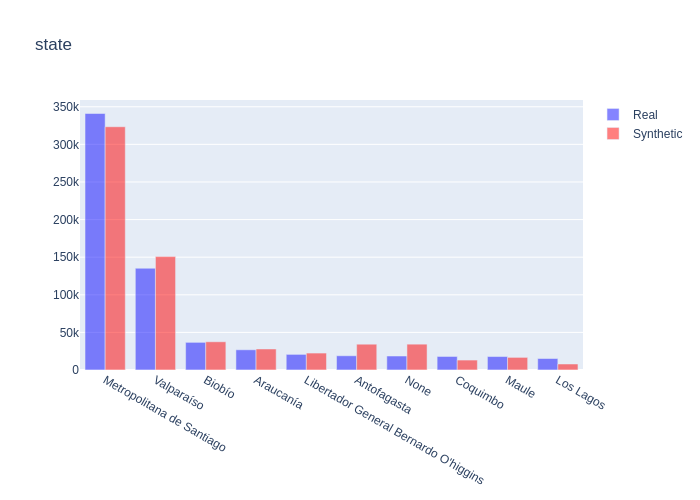

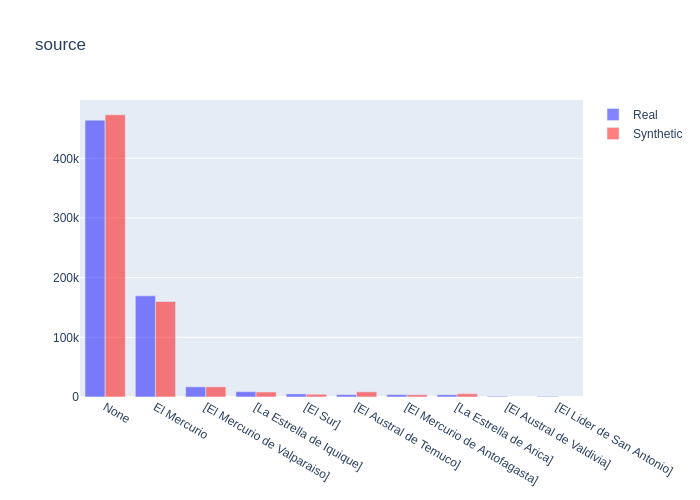

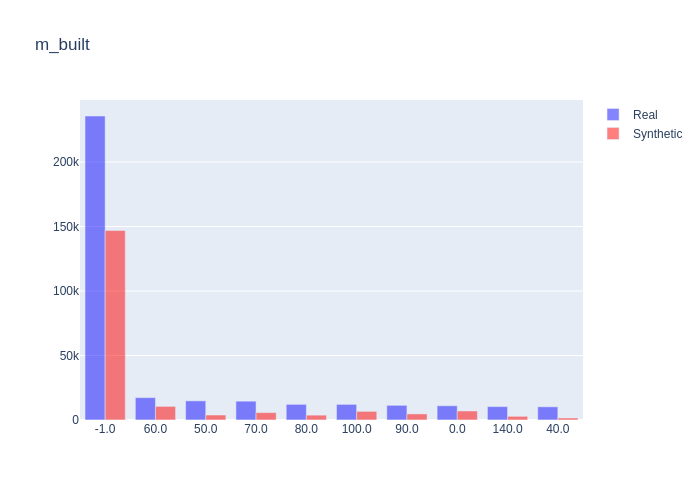

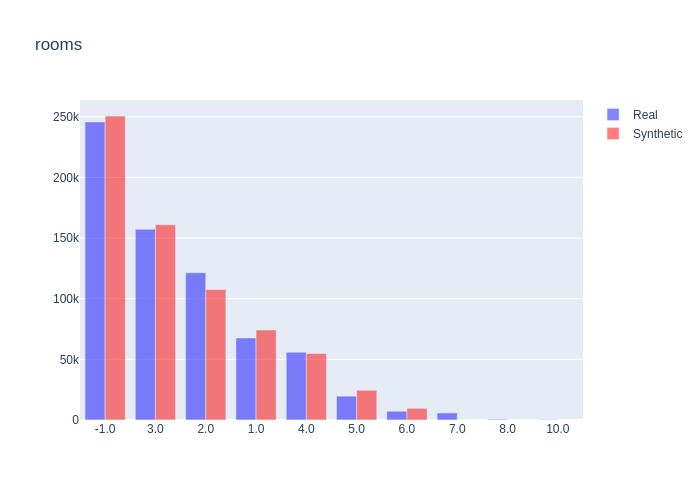

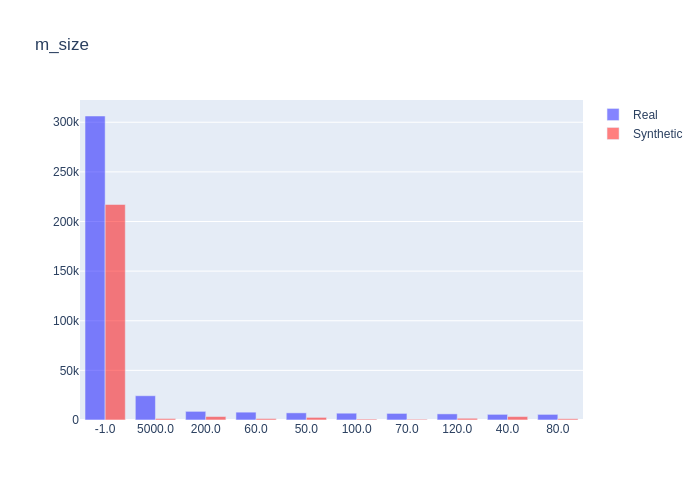

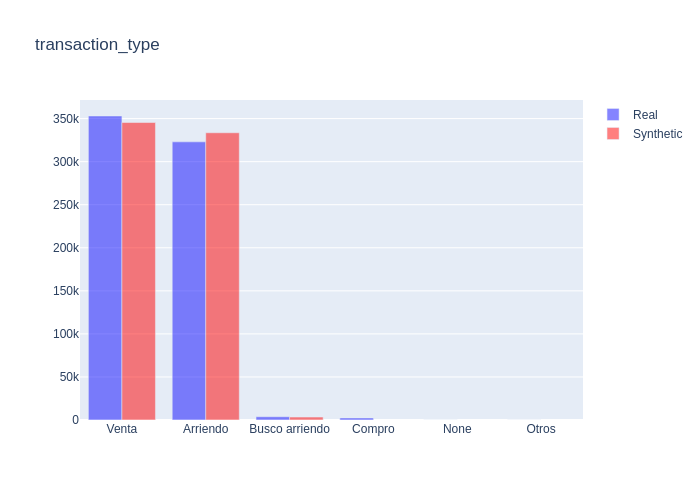

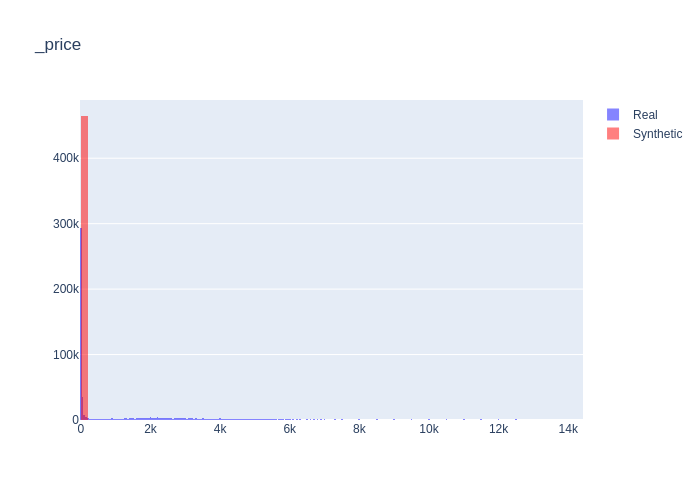

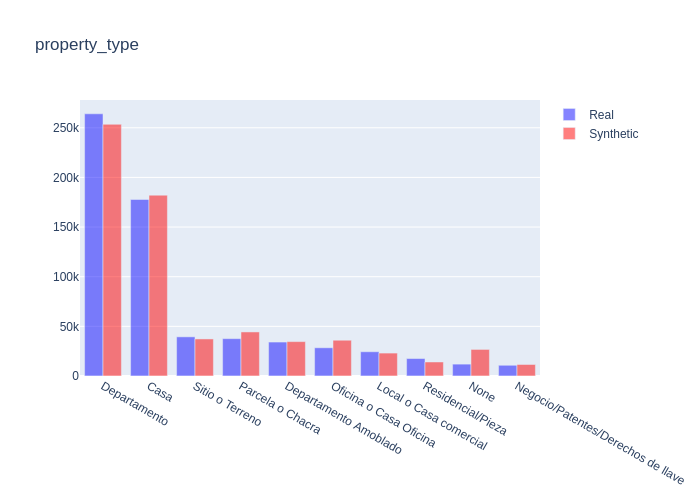

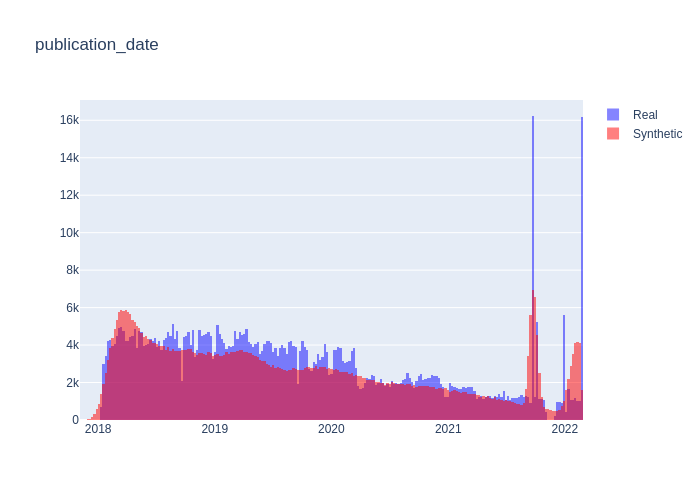

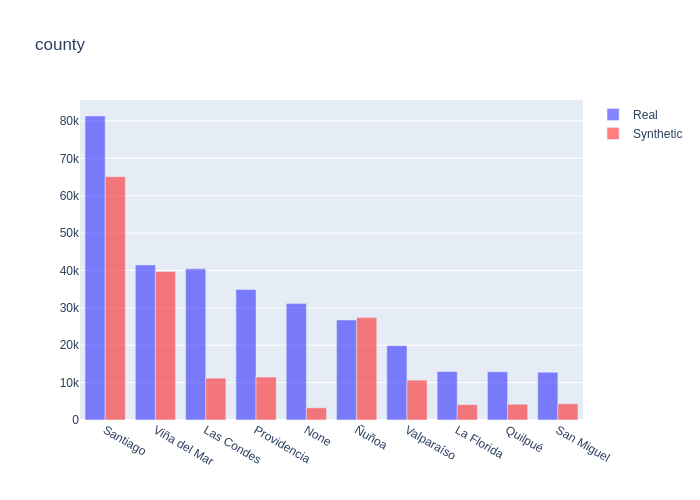

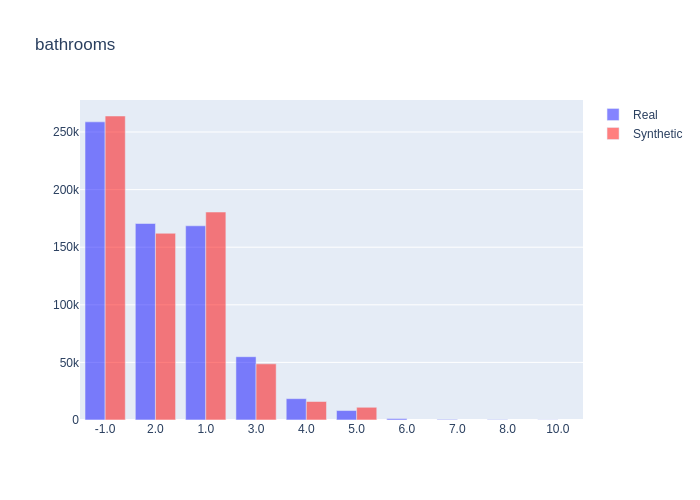

In [10]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts("ctgan"):
    if fig:
        fig.show("png")

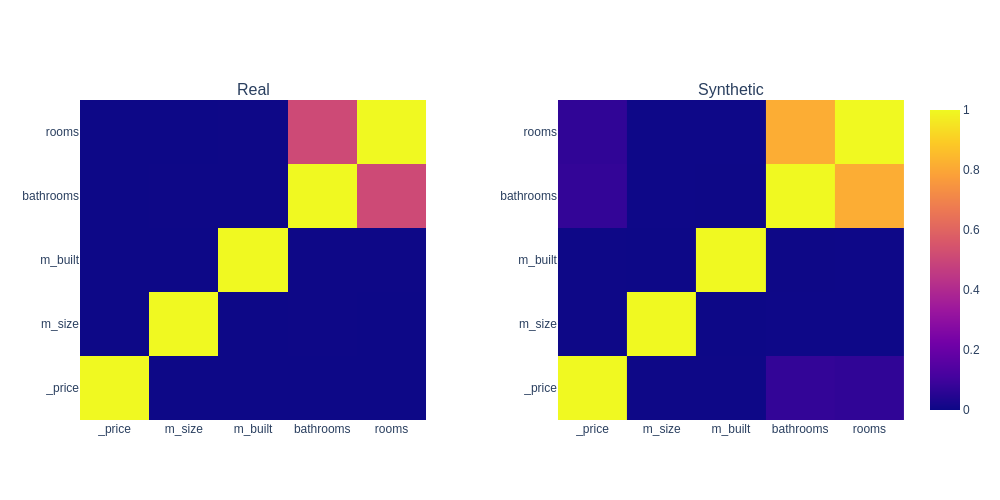

In [11]:
import numpy as np
syn.charts.pair_corr(syn.df.replace({-1: np.NaN}), syn.fake_data['ctgan'], sort_column="rooms").show("png")